In [26]:
import xarray as xr 

import sys
sys.path.append('/home/links/ct715/eddy_feedback')
import functions.eddy_feedback as ef 

In [27]:
ds = xr.open_mfdataset('/home/links/ct715/eddy_feedback/daily_datasets/jra55_djf_ep.nc',
                            parallel=True, chunks={'time': 31})
ds

<xarray.Dataset>
Dimensions:  (time: 5325, lon: 144, lat: 73, level: 37)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    v        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    u        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    ep1      (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    ep2      (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    div1     (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    div2     (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    ubar     (level, lat) float32 dask.array<chunksize=(37, 73), meta=np.ndarray>

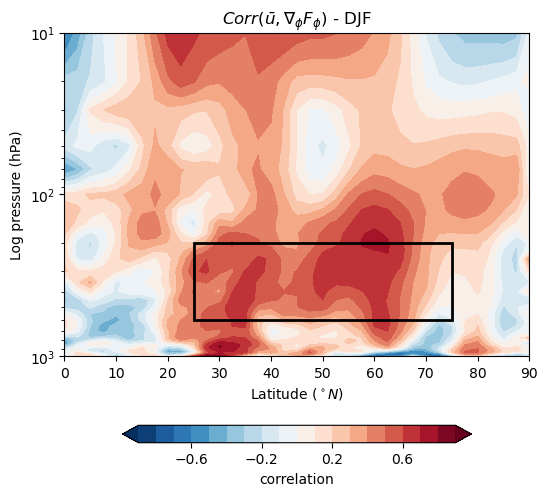

In [28]:
ef.correlation_contourf(ds)

In [43]:
def calculate_ef_parameter(ds, primitive=True, hemisphere='NH', top_atmos=10., reanalysis=True,
                           whole_area=True, which_level=None):

    """ 
    Input: Xarray dataset

    Output: Xarray dataArray of Eddy Feedback Parameter (EFP)
    """

    ## CONDITIONS
    
    # ensure variables are named correctly
    if 'lat' and 'lon' and 'level' and 'u' and 'v' and 't' not in ds:
        ds = ef.find_rename_variables(ds)  
    
    # Check to see if EP fluxes are in DataSet
    if not 'ep1' in ds:
        ds = ef.calculate_epfluxes_ubar(ds, primitive=primitive) 


    # Reduce dataset to 200-600hPa
    ds = ds.where( ds.level >= 200., drop=True ) 
    ds = ds.where( ds.level <= 600., drop=True ) 

    # choose hemisphere
    if hemisphere == 'SH':
        # set southern hermisphere
        ds = ds.where( ds.lat <= 0, drop=True )
    else:
        # set northern hemisphere
        ds = ds.where( ds.lat >= 0, drop=True )


    #-------------------------------------------------------------------

    ## SET UP TIME
    
    # # remove unwanted variables
    # vars = ['u', 'div1', 'div2']
    # ds = ds[vars]
    
    # set variables and save them
    ubar = ds.u.mean(('lon'))
    div1 = ds.div1
    div2 = ds.div2
    
    if reanalysis: 
        # separate time into annual means
        # and use .load() to force the calculation now
        ubar = ubar.groupby('time.year').mean('time').load()
        div1 = div1.groupby('time.year').mean('time').load()
        div2 = div2.groupby('time.year').mean('time').load()
    else:
        # separate time into annual means
        ubar = ubar.load()
        div1 = div1.load()
        div2 = div2.load()

    # calculate Pearson's correlation
    R = xr.corr(div1, ubar, dim='year')

    


    # choose between whole area or individual levels
    if whole_area: 
        # average over 200-600hPa
        R = R.mean(('level'))
    else:
        # take a slice at particular level
        R = R.sel( ds.level == which_level)

    # calculate correlation squared (R^2)
    R = R**2


    return R

In [44]:
R = calculate_ef_parameter(ds)
R 

<xarray.DataArray (lat: 37)>
array([9.83143599e-04, 3.05739715e-02, 2.59861010e-02, 1.16373921e-03,
       1.95843557e-02, 1.23445267e-02, 3.83379995e-03, 8.46522381e-03,
       5.91246008e-02, 1.63339796e-01, 3.01685259e-01, 4.12379024e-01,
       4.26761285e-01, 3.53067881e-01, 2.93817700e-01, 2.76809026e-01,
       3.05433451e-01, 2.70391178e-01, 2.02014796e-01, 1.95075005e-01,
       2.09958001e-01, 2.56945209e-01, 3.69821820e-01, 3.44520406e-01,
       2.67153965e-01, 2.48751917e-01, 1.98005075e-01, 1.22203759e-01,
       4.40189833e-02, 2.54178100e-03, 1.77749543e-04, 2.00924540e-03,
       1.16637316e-02, 1.01064180e-02, 7.28431479e-03, 6.07215362e-03,
       1.11638469e-04])
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... 10.0 7.5 5.0 2.5 0.0

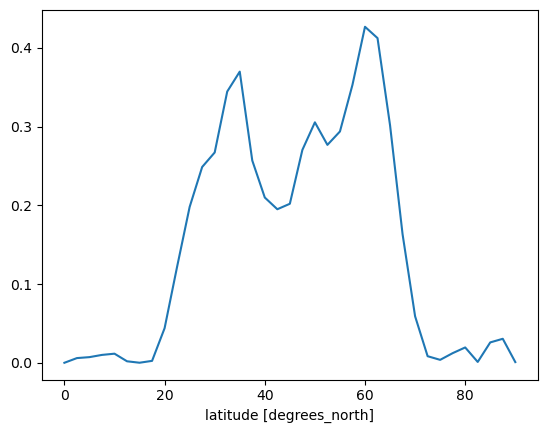

In [45]:
R.plot.line()

In [32]:
R = calculate_ef_parameter(ds)
R

<xarray.DataArray (lat: 37)>
array([9.83143599e-04, 3.05739715e-02, 2.59861010e-02, 1.16373921e-03,
       1.95843557e-02, 1.23445267e-02, 3.83379995e-03, 8.46522381e-03,
       5.91246008e-02, 1.63339796e-01, 3.01685259e-01, 4.12379024e-01,
       4.26761285e-01, 3.53067881e-01, 2.93817700e-01, 2.76809026e-01,
       3.05433451e-01, 2.70391178e-01, 2.02014796e-01, 1.95075005e-01,
       2.09958001e-01, 2.56945209e-01, 3.69821820e-01, 3.44520406e-01,
       2.67153965e-01, 2.48751917e-01, 1.98005075e-01, 1.22203759e-01,
       4.40189833e-02, 2.54178100e-03, 1.77749543e-04, 2.00924540e-03,
       1.16637316e-02, 1.01064180e-02, 7.28431479e-03, 6.07215362e-03,
       1.11638469e-04])
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... 10.0 7.5 5.0 2.5 0.0

In [33]:
def calculate_ef_parameter(ds, primitive=True, hemisphere='NH', top_atmos=10., reanalysis=True,
                           whole_area=True, which_level=None):

    """ 
    Input: Xarray dataset

    Output: Xarray dataArray of Eddy Feedback Parameter (EFP)
    """

    ## CONDITIONS
    
    # ensure variables are named correctly
    if 'lat' and 'lon' and 'level' and 'u' and 'v' and 't' not in ds:
        ds = ef.find_rename_variables(ds)  
    
    # Check to see if EP fluxes are in DataSet
    if not 'ep1' in ds:
        ds = ef.calculate_epfluxes_ubar(ds, primitive=primitive) 


    # Reduce dataset to 200-600hPa
    ds = ds.where( ds.level >= 200., drop=True ) 
    ds = ds.where( ds.level <= 600., drop=True ) 

    # choose hemisphere
    if hemisphere == 'SH':
        # set southern hermisphere
        ds = ds.where( ds.lat <= 0, drop=True )
    else:
        # set northern hemisphere
        ds = ds.where( ds.lat >= 0, drop=True )


    #-------------------------------------------------------------------

    ## SET UP TIME
    
    # remove unwanted variables
    vars = ['u', 'div1', 'div2']
    ds = ds[vars]
    
    # set variables and save them
    ubar = ds.u.mean(('lon'))
    div1 = ds.div1
    div2 = ds.div2
    
    if reanalysis:
        # separate time into annual means
        # and use .load() to force the calculation now
        ubar = ubar.groupby('time.year').mean('time').load()
        div1 = div1.groupby('time.year').mean('time').load()
        div2 = div2.groupby('time.year').mean('time').load()
    else:
        # separate time into annual means
        ubar = ubar.load()
        div1 = div1.load()
        div2 = div2.load()

    # calculate Pearson's correlation
    R = xr.corr(ubar, div1, dim='year')

    # calculate correlation squared (R^2)
    R = R**2

    print(R)


    # choose between whole area or individual levels
    if whole_area == True: 
        # average over 200-600hPa
        # R = R.mean(('level'))

        # integrate over levels
        R = R.integrate('level')

    else:
        # take a slice at particular level
        R = R.sel( ds.level == which_level)


    return R

In [34]:
R1 = calculate_ef_parameter(ds)
R1

<xarray.DataArray (level: 10, lat: 37)>
array([[4.52109789e-03, 3.74281076e-02, 2.28659989e-03, 1.63974798e-02,
        5.43981488e-02, 5.13205242e-02, 5.03238593e-02, 6.90935416e-02,
        1.14733351e-01, 2.37023341e-01, 4.13782125e-01, 5.05816296e-01,
        5.26056885e-01, 4.96228299e-01, 4.13078666e-01, 3.31861817e-01,
        2.80598671e-01, 2.11304988e-01, 1.43489307e-01, 1.35282963e-01,
        2.23256069e-01, 2.56044734e-01, 2.83183583e-01, 3.74984022e-01,
        2.87437563e-01, 1.13368558e-01, 4.05604643e-02, 4.43945606e-02,
        8.44662275e-02, 1.18652755e-01, 1.44040781e-01, 9.54165356e-02,
        1.34976450e-02, 4.78596691e-03, 4.46155415e-02, 2.09083427e-02,
        2.49691318e-02],
       [1.91058451e-04, 5.05698631e-02, 1.42420850e-02, 7.20020861e-03,
        3.81623066e-02, 3.39374584e-02, 3.33872381e-02, 5.61061975e-02,
        1.08497859e-01, 2.28219459e-01, 4.23533633e-01, 4.97490309e-01,
        4.83188739e-01, 4.79198353e-01, 4.48775110e-01, 4.04015386e-01,

<xarray.DataArray (lat: 37)>
array([ 10.96448385,  11.70037176,  12.5994027 ,   0.92529474,
         7.05271882,   4.41894437,   3.62005645,   9.89777247,
        27.37602567,  63.16844579, 116.18824731, 159.91554469,
       166.72817773, 139.66870981, 120.47742601, 118.27858157,
       131.24385971, 117.10021425,  88.84938885,  85.22461344,
        93.41624358, 112.10588319, 155.8529651 , 138.46475595,
       104.84318872, 105.05945837,  90.02733179,  54.57500714,
        16.75531431,   3.85832393,  14.29029584,  21.74503331,
        24.67263039,  14.91697003,  17.6645474 ,  10.6290573 ,
        17.47260331])
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... 10.0 7.5 5.0 2.5 0.0

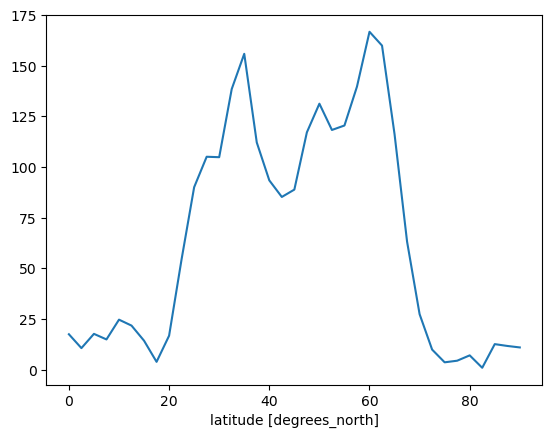

In [35]:
R1.plot()